### WBS Coding School
___
### --PROJECT--
# Movie Recommender

In this **Movie Recommendation** project I create several recommendation systems that suggest movies to watch. I manually develop both a popularity-based and an item-based recommender, and subsequently use sklearn's `surprise` library to create a user-based recommender. These recommenders will be used to create a `streamlit` app, the code of which can be found in the `app.py` module.

This is a learning project, in which I practice building recommenders and try to understand their fundamental concepts.

I used the movie ratings dataset from [MovieLens](http://movielens.org). It includes 100k 5-star ratings from 610 users of almost 10k different movies. It is publicly available for download at <http://grouplens.org/datasets/>. Credit goes to:
> F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19. <https://doi.org/10.1145/2827872>
___

## Table of contents:
- [1. Data Exploration](#exploration)
- [2. Popularity Recommender](#popularity)
    - [2.1. Ratings & Popularity Metrics](#metrics)
    - [2.2. Combined Metric](#combined)
    - [2.3. Popularity Recommender Function](#recommender_function)
- [3. Item-based Recommender](#item)
    - [3.1 How to Recommend Similar Movies](#how_to)
    - [3.2 Function for Recommending Similar Movies](#similar_movies_function)
- [4. User-based Recommender](#user)
    - [4.1. Model Testing](#testing)
    - [4.2. Model for Usage](#usage)
    - [4.3 Function for Recommending What Others Like](#user_based_function)

#### Libraries and Data

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn import set_config
from sklearn.metrics.pairwise import cosine_similarity

from surprise import Reader, Dataset, KNNBasic, SVD, accuracy
from surprise.model_selection import train_test_split

In [55]:
movies = pd.read_csv("data/movies.csv")
ratings = pd.read_csv("data/ratings.csv")
tags = pd.read_csv("data/tags.csv")
links = pd.read_csv("data/links.csv")

___
<a id="exploration"></a>
## 1.&nbsp; Data Exploration 🔎

The dataset stems from [MovieLens](http://movielens.org), a movie recommendation service. It contains 100,836 ratings and 3,683 tag applications across 9,742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.

In [56]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [57]:
# Duplicate movie titles
movies.loc[movies["title"].duplicated(), :]

,movieId,title,genres
5601,26958,Emma (1996),Romance
6932,64997,War of the Worlds (2005),Action|Sci-Fi
9106,144606,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Romance|Thriller
9135,147002,Eros (2004),Drama|Romance
9468,168358,Saturn 3 (1980),Sci-Fi|Thriller


In [58]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [59]:
print("Number of duplicates: ", movies.duplicated().sum())
print("Number of NAs: ", movies.isna().any().sum())

Number of duplicates:  0
Number of NAs:  0


Pretty clean movie data, with almost 10k movies and only a couple of duplicate movie titles.

___

In [60]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [61]:
ratings["rating"].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [62]:
ratings["rating"].value_counts(normalize=True).round(2)

4.0    0.27
3.0    0.20
5.0    0.13
3.5    0.13
4.5    0.08
2.0    0.07
2.5    0.06
1.0    0.03
1.5    0.02
0.5    0.01
Name: rating, dtype: float64

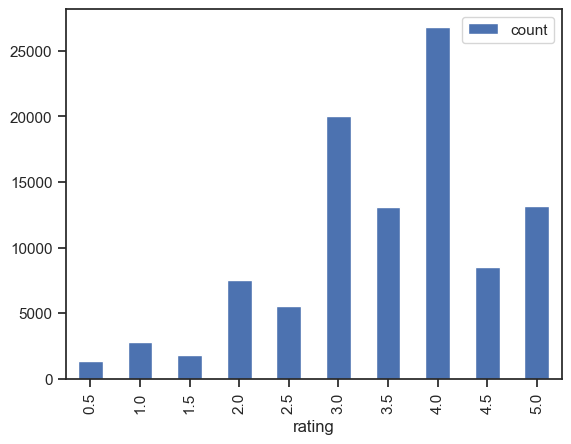

In [63]:
plot_ratings = ratings.groupby("rating").agg(count=("rating", "count")).reset_index()
plot_ratings.plot.bar(y="count", x="rating");

In [64]:
print("Number of duplicates: ", ratings.duplicated().sum())
print("Number of NAs: ", ratings.isna().any().sum())

Number of duplicates:  0
Number of NAs:  0


There are 100k ratings, ten times as much as there are movies. Ratings range from 0.5 to 5.0 in incremental steps of 0.5. Half of them are 3s and 4s. Interestingly, people seem to prefer whole number ratings over half stars.

___

In [65]:
tags.sort_values("movieId")

,userId,movieId,tag,timestamp
2886,567,1,fun,1525286013
981,474,1,pixar,1137206825
629,336,1,pixar,1139045764
35,62,2,Robin Williams,1528843907
34,62,2,magic board game,1528843932
...,...,...,...,...
402,62,187595,star wars,1528934552
528,184,193565,comedy,1537098587
527,184,193565,anime,1537098582
530,184,193565,remaster,1537098592


In [66]:
tags.value_counts("tag")

tag
In Netflix queue            131
atmospheric                  36
thought-provoking            24
superhero                    24
Disney                       23
                           ... 
beautifully filmed            1
beautiful visuals             1
beautiful cinematography      1
beat poetry                   1
"artsy"                       1
Length: 1589, dtype: int64

In [67]:
print("Number of duplicates: ", tags.duplicated().sum())
print("Number of NAs: ", tags.isna().any().sum())

Number of duplicates:  0
Number of NAs:  0


There are 3.7k tags, roughly one third of the number of movies. They are very heterogeneously distributed, with no meaningful label occurring more often than 36 times. 

Often, a similar characteristic is expressed by multiple slightly different labels (e.g. "beautifully filmed", "beautiful visuals", "beautiful cinematography").

___
<a id="popularity"></a>
## 2.&nbsp; Popularity Recommender ⭐

We'll code a popularity-based, non-personalised recommender system that takes as an input the ratings and movies datasets and outputs the “best” movies. Those movies will appear as the top row of our imaginary website.

We'll create a function that takes an input `n_movies` (how many movies we wish to display) and outputs the top **n most popular movies** based on **ratings** and **number of ratings**.

<a id="metrics"></a>
### 2.1.&nbsp; Ratings & Popularity Metrics

In [68]:
# Calculate popularity and movie ratings
popularity_metrics = ratings.groupby("movieId").agg({
    "rating": "mean",
    "movieId": "count"
})
popularity_metrics.columns = ['avg_rating', 'number_of_ratings']

popularity_metrics

,avg_rating,number_of_ratings
movieId,,
1,3.920930,215
2,3.431818,110
3,3.259615,52
4,2.357143,7
5,3.071429,49
...,...,...
193581,4.000000,1
193583,3.500000,1
193585,3.500000,1


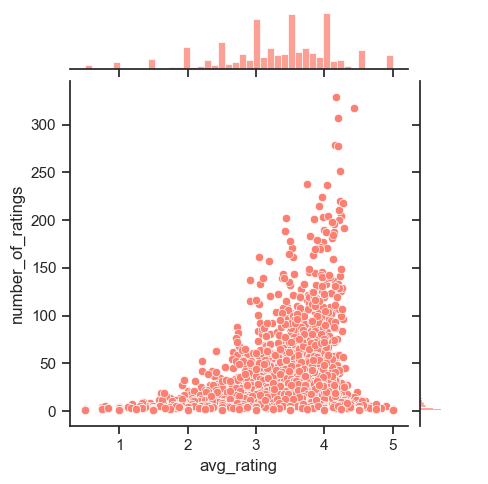

In [69]:
sns.set_theme(style="ticks")
sns.jointplot(
    data=popularity_metrics, 
    x="avg_rating", y="number_of_ratings", 
    color=sns.color_palette("Set3", 6)[3], height=5);

Our `number_of_ratings` is highly **left-skewed**, because most movies have **only been rated once**. However, we do not use any statistical models that require normally distributed data, meaning we don't need to normalize them.

<a id="combined"></a>
### 2.2.&nbsp; Combined Metric

Let's calculate a metric that **combines** the **average movie rating** with the **number of times** a movie was rated:

`combined_metric` = 2 * `avg_rating` + `number_of_ratings`

I'll give the average rating of a movie more weight than the number of times a movie was rated, because I believe it's a more important quality feature.

In [70]:
popularity_metrics["combined_metric"] = (
    (2 * popularity_metrics["avg_rating"]) + (1 * popularity_metrics["number_of_ratings"]))
# The 10 best movies based on the combined metric
popularity_metrics.nlargest(10, "combined_metric")

,avg_rating,number_of_ratings,combined_metric
movieId,,,
356,4.164134,329,337.328267
318,4.429022,317,325.858044
296,4.197068,307,315.394137
593,4.161290,279,287.322581
2571,4.192446,278,286.384892
260,4.231076,251,259.462151
480,3.750000,238,245.500000
110,4.031646,237,245.063291
589,3.970982,224,231.941964


The best ranking movies that can well be recommended are the following:

In [71]:
top10_movieIDs = popularity_metrics.reset_index().nlargest(10, "combined_metric")["movieId"]
movie_cols = ["title", "genres"]
top10_movies = movies.loc[movies["movieId"].isin(top10_movieIDs), movie_cols].drop_duplicates()
top10_movies.insert(0, column="ranking", value=range(1,11,1))

In [72]:
top10_movies

,ranking,title,genres
97,1,Braveheart (1995),Action|Drama|War
224,2,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
257,3,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
277,4,"Shawshank Redemption, The (1994)",Crime|Drama
314,5,Forrest Gump (1994),Comedy|Drama|Romance|War
418,6,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
461,7,Schindler's List (1993),Drama|War
507,8,Terminator 2: Judgment Day (1991),Action|Sci-Fi
510,9,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
1939,10,"Matrix, The (1999)",Action|Sci-Fi|Thriller


<a id="recommender_function"></a>
### 2.3.&nbsp; Popularity Recommender Function

Let's bring it all together in a function.

In [73]:
def recommend_most_popular_movies(
        ratings_df: pd.DataFrame,
        movies_df: pd.DataFrame,
        n_movies: int):

    print("Most popular movies:\n")

    # Popularity metrics dataframe
    popularity_metrics = ratings_df.groupby("movieId").agg({
        "rating": "mean",
        "movieId": "count"
    })
    popularity_metrics.columns = ['avg_rating', 'number_of_ratings']

    # Combined metric
    popularity_metrics["combined_metric"] = (
        (2 * popularity_metrics["avg_rating"]) + (1 * popularity_metrics["number_of_ratings"]))

    # Select most popular movies
    top_n_movie_IDs = popularity_metrics.reset_index().nlargest(n_movies, "combined_metric")["movieId"]
    movie_cols = ["title", "genres"]
    top_n_movies = movies_df.loc[movies_df["movieId"].isin(top_n_movie_IDs), movie_cols].drop_duplicates()
    top_n_movies.insert(0, column="ranking", value=range(1, n_movies+1, 1))

    return top_n_movies

In [74]:
recommend_most_popular_movies(ratings_df=ratings, movies_df=movies, n_movies=10)

Most popular movies:



,ranking,title,genres
97,1,Braveheart (1995),Action|Drama|War
224,2,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
257,3,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
277,4,"Shawshank Redemption, The (1994)",Crime|Drama
314,5,Forrest Gump (1994),Comedy|Drama|Romance|War
418,6,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
461,7,Schindler's List (1993),Drama|War
507,8,Terminator 2: Judgment Day (1991),Action|Sci-Fi
510,9,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
1939,10,"Matrix, The (1999)",Action|Sci-Fi|Thriller


___
<a id="item"></a>
## 3.&nbsp; Item-based Recommender 🟰

An item-based similarity recommending system takes an item, in our case a movie, as an input and outputs a list of similar movies. 

The similarity is based on rating correlations from a user-item matrix. The recommender will look at how all users rated the input movie and suggest movies that were rated similarly. Effectively, this does not select by genre but rather by user preferences. If lots of users that like romantic films also like horror movies, then the recommender will mix these two genres.

<a id="how_to"></a>
### 3.1.&nbsp; How to Recommend Similar Movies

Let's build an item-based recommender step by step.

We'll first generate a user-item matrix that includes movie ratings from all users. From that, we'll calculate the similarities between movies using cosine similarity. Then, we'll filter for the selected movie and only pick similar movies that were rated by a sufficient number of users. Finally, we select the movies with the highest similarity.

In [75]:
# Selected movie
movie_id = 1
print("Selected movie: ", movies.loc[movies["movieId"]==movie_id, "title"][0])

Selected movie:  Toy Story (1995)


In [76]:
# User-item matrix
user_movie_matrix = pd.pivot_table(
    data=ratings,
    values='rating',
    index='userId',
    columns='movieId',
    fill_value=0)

user_movie_matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0,0.0,4.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0


Next up, we'll calculate the **cosine similarity** between all movies. 

Cosine similarity judges similarity based on the direction of vectors. Get into mathematical depth [here](https://www.leydesdorff.net/cosinevspearson/#:~:text=The%20Pearson%20correlation%20normalizes%20the,of%20zero%20(Figure%201).).

In [77]:
# (Cosine) Similarity matrix
movie_similarity_matrix = pd.DataFrame(
    cosine_similarity(user_movie_matrix.T),
    columns=user_movie_matrix.columns,
    index=user_movie_matrix.columns)

movie_similarity_matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.410562,0.296917,0.035573,0.308762,0.376316,0.277491,0.131629,0.232586,0.395573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.410562,1.000000,0.282438,0.106415,0.287795,0.297009,0.228576,0.172498,0.044835,0.417693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.296917,0.282438,1.000000,0.092406,0.417802,0.284257,0.402831,0.313434,0.304840,0.242954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.035573,0.106415,0.092406,1.000000,0.188376,0.089685,0.275035,0.158022,0.000000,0.095598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.308762,0.287795,0.417802,0.188376,1.000000,0.298969,0.474002,0.283523,0.335058,0.218061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
193583,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
193585,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [78]:
# Similarities for selected movie
movie_similarities = pd.DataFrame(movie_similarity_matrix[movie_id])
movie_similarities = (
    movie_similarities.loc[movie_similarities.index != movie_id, :] # we only want the similar movies, not 
    .rename(columns={movie_id: "movie_similarities"})
    .sort_values("movie_similarities", ascending=False))

# Filter for number of users who rated both movies
no_of_users_rated_both_movies = [
    sum((user_movie_matrix[movie_id] > 0) & 
        (user_movie_matrix[isbn] > 0)) for isbn in movie_similarities.index]
movie_similarities["users_who_rated_both_movies"] = no_of_users_rated_both_movies
movie_similarities = movie_similarities[
    movie_similarities["users_who_rated_both_movies"] > 10]

movie_similarities

,movie_similarities,users_who_rated_both_movies
movieId,,
3114,0.572601,81
480,0.565637,132
780,0.564262,122
260,0.557388,134
356,0.547096,154
...,...,...
105,0.131479,11
112552,0.126563,15
106489,0.120064,11


In [79]:
# Select top n similar movies
movie_cols = ["title", "genres"]
top_n_similar_movies = (
    movie_similarities
    .head()
    .reset_index()
    .merge(movies.drop_duplicates(subset='movieId'),
            on='movieId',
            how='left')
    [movie_cols + ["movie_similarities", "users_who_rated_both_movies"]])

top_n_similar_movies

,title,genres,movie_similarities,users_who_rated_both_movies
0,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,0.572601,81
1,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,0.565637,132
2,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller,0.564262,122
3,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,0.557388,134
4,Forrest Gump (1994),Comedy|Drama|Romance|War,0.547096,154


<a id="similar_movies_function"></a>
### 3.2.&nbsp; Function for Recommending Similar Movies

Let's bring it all together in a function.

In [80]:
def recommend_similar_movies(
        ratings_df: pd.DataFrame,
        movies_df: pd.DataFrame,
        movie_id: int,
        top_n_movies: int,
        no_of_users_threshold: int):
    
    # Selected movie
    print("Selected movie: ", movies_df.loc[movies_df["movieId"]==movie_id, "title"][0])
    print("\nSimilar movies:\n")

    # User-item matrix
    user_movie_matrix = pd.pivot_table(
        data=ratings_df,
        values='rating',
        index='userId',
        columns='movieId',
        fill_value=0)
    # (Cosine) Similarity matrix
    movie_similarity_matrix = pd.DataFrame(
        cosine_similarity(user_movie_matrix.T),
        columns=user_movie_matrix.columns,
        index=user_movie_matrix.columns)
    
    # Similarities for selected movie
    movie_similarities = pd.DataFrame(movie_similarity_matrix[movie_id])
    movie_similarities = (
        movie_similarities.loc[movie_similarities.index != movie_id, :]
        .rename(columns={movie_id: "movie_similarities"})
        .sort_values("movie_similarities", ascending=False))
    
    # Filter for number of users who rated both movies
    no_of_users_rated_both_movies = [
        sum((user_movie_matrix[movie_id] > 0) & 
            (user_movie_matrix[isbn] > 0)) for isbn in movie_similarities.index]
    movie_similarities["users_who_rated_both_movies"] = no_of_users_rated_both_movies
    movie_similarities = movie_similarities[
        movie_similarities["users_who_rated_both_movies"] > no_of_users_threshold]
    
    # Select top n similar movies
    movie_cols = ["title", "genres"]
    top_n_similar_movies = (
        movie_similarities
        .head(top_n_movies)
        .reset_index()
        .merge(movies_df.drop_duplicates(subset='movieId'),
                on='movieId',
                how='left')
        [movie_cols + ["movie_similarities", "users_who_rated_both_movies"]])

    return top_n_similar_movies

In [81]:
recommend_similar_movies(
    ratings, movies, 
    movie_id=1, 
    top_n_movies=5, 
    no_of_users_threshold=10)

Selected movie:  Toy Story (1995)

Similar movies:



,title,genres,movie_similarities,users_who_rated_both_movies
0,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,0.572601,81
1,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,0.565637,132
2,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller,0.564262,122
3,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,0.557388,134
4,Forrest Gump (1994),Comedy|Drama|Romance|War,0.547096,154


___
<a id="user"></a>
## 4.&nbsp; User-based Recommender 🟰

User-based recommenders are like having a knowledgeable friend who knows your preferences inside out and suggests things tailored specifically to your taste. These recommenders analyse your past interactions, such as watched movies or likes, to find users with similar preferences and recommend items they have enjoyed.

They are really good at capturing the nuances of your preferences and offering suggestions that are more tailored to your unique taste. However, they may have limitations when there is limited data available or when users' preferences change over time.

We'll here use sklearn's `surprise` machine learning library to make our life a little easier. Instead of coding our user-based recommender manually, `surprise` will automate lots of tasks for us.

<a id="testing"></a>
### 4.1.&nbsp; Model Testing

We'll here test and compare two different models, a **K-nearest neighbors (KNN)** and a **Singular Value Decomposition (SVD)** model. 

In [82]:
# Define reader and load data
reader = Reader(rating_scale=(0.5, 5)) # our ratings range from 0.5 to 5
data = Dataset.load_from_df(ratings[["userId", "movieId", "rating"]], reader)

# Split data
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [83]:
# Options for the similarity measure
knn_options = { 
    'name': 'cosine',
    'user_based': True
}

# Basic nearest neighbors algorithm
knn = KNNBasic(sim_options=knn_options)
svd = SVD(
    n_factors=150, n_epochs=30, 
    lr_all=0.01, reg_all=0.1, 
    random_state=42)

svd.fit(trainset)
knn.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [84]:
# Make predictions on the test set
predictions_knn = knn.test(testset)
predictions_svd = svd.test(testset)

In [85]:
predictions_knn[:5]
predictions_svd[:5]

[Prediction(uid=140, iid=6765, r_ui=3.5, est=3.337923534955936, details={'was_impossible': False}),
 Prediction(uid=603, iid=290, r_ui=4.0, est=4.016732257805406, details={'was_impossible': False}),
 Prediction(uid=438, iid=5055, r_ui=4.0, est=3.1253306764770232, details={'was_impossible': False}),
 Prediction(uid=433, iid=164179, r_ui=5.0, est=3.638820280152489, details={'was_impossible': False}),
 Prediction(uid=474, iid=5114, r_ui=4.0, est=3.344569989229585, details={'was_impossible': False})]

The `test` function tests the algorithm on our test set. The resulting predictions are a list of tuples:

- `uid`: &nbsp; &nbsp; &nbsp; &nbsp; Represents the raw user ID
- `iid`: &nbsp; &nbsp; &nbsp; &nbsp; Represents the raw item ID
- `r_ui`: &nbsp; &nbsp; &nbsp; Denotes the true rating provided by the user
- `est`: &nbsp; &nbsp; &nbsp; &nbsp; Represents the estimated rating calculated by the model
- `details`:Additional information about the prediction

In [86]:
# Make a dataframe from predictions
predictions_df_knn = pd.DataFrame(
    predictions_knn, 
    columns=[
        "raw_user_id", "raw_item_id", 
        "actual_user_rating", "estimated_user_rating", "details"])

predictions_df_svd = pd.DataFrame(
    predictions_svd, 
    columns=[
        "raw_user_id", "raw_item_id", 
        "actual_user_rating", "estimated_user_rating", "details"])

In [102]:
print("KNN model performance:\n")
accuracy.mae(predictions_knn)
accuracy.rmse(predictions_knn)
accuracy.fcp(predictions_knn)

KNN model performance:

MAE:  0.7559
RMSE: 0.9823
FCP:  0.6664


0.6663902108054506

In [101]:
print("SVD model performance:\n")
accuracy.mae(predictions_svd)
accuracy.rmse(predictions_svd)
accuracy.fcp(predictions_svd)

SVD model performance:

MAE:  0.6608
RMSE: 0.8621
FCP:  0.6737


0.6736671508759361

<a id="usage"></a>
### 4.2.&nbsp; Model for Usage

The KNN model performed better than the SVD algorithm. We'll hence go for the KNN one to build our final model.

We'll use the whole dataset to train the final model. The method `build_full_trainset` creates that dataset. We'll pair it with `build_anti_testset()`, which creates a test set for predicting items that users haven't rated yet. It simulates scenarios where the recommendation system suggests new items to users.

In [89]:
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[["userId", "movieId", "rating"]], reader)

# Create the complete training set
all_training_data = data.build_full_trainset()
# Create a complementary testing set
testset = all_training_data.build_anti_testset()

# Fit the model on training data
similarity_options = { 
    'name': 'cosine',
    'user_based': True
}
final_model = KNNBasic(sim_options=similarity_options)
final_model.fit(all_training_data)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [90]:
predictions = final_model.test(testset)

In [91]:
pd.DataFrame(predictions)

,uid,iid,r_ui,est,details
0,1,318,3.501557,4.661920,"{'actual_k': 40, 'was_impossible': False}"
1,1,1704,3.501557,4.312342,"{'actual_k': 40, 'was_impossible': False}"
2,1,6874,3.501557,4.037832,"{'actual_k': 40, 'was_impossible': False}"
3,1,8798,3.501557,3.825442,"{'actual_k': 40, 'was_impossible': False}"
4,1,46970,3.501557,3.248789,"{'actual_k': 28, 'was_impossible': False}"
...,...,...,...,...,...
5830799,610,7377,3.501557,3.500000,"{'actual_k': 1, 'was_impossible': False}"
5830800,610,8667,3.501557,3.500000,"{'actual_k': 1, 'was_impossible': False}"
5830801,610,32302,3.501557,4.000000,"{'actual_k': 1, 'was_impossible': False}"
5830802,610,51903,3.501557,2.500000,"{'actual_k': 1, 'was_impossible': False}"


In [92]:
# Get the top predicted movies for specified user
def get_top_n(testset: list, model, user_id: int, top_n: int):
    
    # Filter the testset to include only rows with the specified user_id
    filtered_testset = [row for row in testset if row[0] == user_id]

    # Make predictions on the filtered testset
    predictions = model.test(filtered_testset)

    # Create a DataFrame from the predictions and return the top n predictions based on the estimated ratings ('est')
    top_n_predictions_df = pd.DataFrame(predictions).nlargest(top_n, 'est')

    return top_n_predictions_df

In [93]:
top_n_movies = get_top_n(testset=testset, model=final_model, user_id=10, top_n=10)
top_n_movies

,uid,iid,r_ui,est,details
248,10,131724,3.501557,5.0,"{'actual_k': 1, 'was_impossible': False}"
413,10,3851,3.501557,5.0,"{'actual_k': 1, 'was_impossible': False}"
2369,10,685,3.501557,5.0,"{'actual_k': 1, 'was_impossible': False}"
2516,10,1105,3.501557,5.0,"{'actual_k': 1, 'was_impossible': False}"
2913,10,1151,3.501557,5.0,"{'actual_k': 2, 'was_impossible': False}"
2915,10,1631,3.501557,5.0,"{'actual_k': 1, 'was_impossible': False}"
2916,10,1696,3.501557,5.0,"{'actual_k': 1, 'was_impossible': False}"
2920,10,2075,3.501557,5.0,"{'actual_k': 1, 'was_impossible': False}"
2988,10,176601,3.501557,5.0,"{'actual_k': 1, 'was_impossible': False}"
3021,10,92494,3.501557,5.0,"{'actual_k': 1, 'was_impossible': False}"


In [94]:
top_n_movie_IDs = top_n_movies["iid"].tolist()
top_n_movies_metadata = movies.loc[movies["movieId"].isin(top_n_movie_IDs),:]
final_movies = (
    top_n_movies.merge(top_n_movies_metadata, how="left", left_on="iid", right_on="movieId"))
    # .drop(columns=["iid", "r_ui", "est", "details"]))

final_movies

,uid,iid,r_ui,est,details,movieId,title,genres
0,10,131724,3.501557,5.0,"{'actual_k': 1, 'was_impossible': False}",131724,The Jinx: The Life and Deaths of Robert Durst ...,Documentary
1,10,3851,3.501557,5.0,"{'actual_k': 1, 'was_impossible': False}",3851,I'm the One That I Want (2000),Comedy
2,10,685,3.501557,5.0,"{'actual_k': 1, 'was_impossible': False}",685,It's My Party (1996),Drama
3,10,1105,3.501557,5.0,"{'actual_k': 1, 'was_impossible': False}",1105,Children of the Corn IV: The Gathering (1996),Horror
4,10,1151,3.501557,5.0,"{'actual_k': 2, 'was_impossible': False}",1151,Lesson Faust (1994),Animation|Comedy|Drama|Fantasy
5,10,1631,3.501557,5.0,"{'actual_k': 1, 'was_impossible': False}",1631,"Assignment, The (1997)",Action|Thriller
6,10,1696,3.501557,5.0,"{'actual_k': 1, 'was_impossible': False}",1696,Bent (1997),Drama|War
7,10,2075,3.501557,5.0,"{'actual_k': 1, 'was_impossible': False}",2075,Mephisto (1981),Drama|War
8,10,176601,3.501557,5.0,"{'actual_k': 1, 'was_impossible': False}",176601,Black Mirror,(no genres listed)
9,10,92494,3.501557,5.0,"{'actual_k': 1, 'was_impossible': False}",92494,Dylan Moran: Monster (2004),Comedy|Documentary


<a id="user_based_function"></a>
### 4.3.&nbsp; Function for Recommending What Others Like

Let's write a function that recommends a specific users what similar users like.

In [110]:
def recommend_what_others_like(
        ratings_df: pd.DataFrame,
        movies_df: pd.DataFrame,
        user_id: int, 
        top_n: int):
    
    # Define reader and load data
    reader = Reader(rating_scale=(0.5, 5))
    data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)
    trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
    # Filter the testset to include only rows for the specified user
    filtered_testset = [row for row in testset if row[0] == user_id]

    # Create and train KNN model
    knn_options = {'name': 'cosine', 'user_based': True}
    model = KNNBasic(sim_options=knn_options)
    model.fit(trainset)

    # Make predictions on the filtered test set
    predictions = model.test(filtered_testset)
    predictions_df = pd.DataFrame(predictions, columns=['uid', 'iid', 'r_ui', 'est', 'details'])
    # Return the top n recommended movies
    movies = predictions_df.nlargest(top_n, 'est') # 'est' => estimated rating

    # Get the movie names
    movie_IDs = movies["iid"].tolist()
    movie_names = movies_df.loc[
        movies_df["movieId"].isin(movie_IDs), ["movieId", "title"]]
    # Merge the predictions
    movies_final = movies.merge(
        movie_names, 
        how="left", left_on="iid", right_on="movieId")

    return movies_final["title"]

In [111]:
recommend_what_others_like(ratings, movies, user_id=10, top_n=10)

Computing the cosine similarity matrix...
Done computing similarity matrix.


0                                   Matrix, The (1999)
1                                    Fight Club (1999)
2    Lord of the Rings: The Fellowship of the Ring,...
3                              Sixth Sense, The (1999)
4                                  Finding Nemo (2003)
5                              Incredibles, The (2004)
6                               Sherlock Holmes (2009)
7                      Priceless (Hors de prix) (2006)
8                                    About Time (2013)
9                                    Mean Girls (2004)
Name: title, dtype: object

There we go.

Now we have three different recommenders:
- one for the most popular movies,
- one that takes an input movie and suggests similar ones (item-based)
- and a final one that recommends movies for a specific user (user-based).

In a next step, we'll take the recommenders we created and bring them together in a self-made `streamlit` app. Check out the `app.py` for the code and to start the app.